In [1]:
!pip install transformers
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install torchtext

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torchtext
import torchtext.vocab as vocab
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score


In [4]:
#seed random number generator
torch.manual_seed(14124)

In [5]:
device = torch.device("cuda")

In [6]:
# Prepare the dataset
# Read the CSV file
data = pd.read_csv('data.csv')

# Splitting data into features and labels
X = data['tweet'].values

# Splitting the dataset into training and validation sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Creating DataFrame for training and validation sets
train_data = pd.DataFrame({'tweet': X_train})
test_data = pd.DataFrame({'tweet': X_test})

In [7]:
# Target Model

# # Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
target_model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [8]:
# For validation w.r.t. the target model (but does it technically increases the number of queries?)
def get_label(input_text):
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Query the target model
    with torch.no_grad():
        target_outputs = target_model(**inputs)

    target_labels = target_outputs.logits.softmax(dim=1).tolist()[0]
    return target_labels

test_data['label'] = test_data['tweet'].apply(get_label) # ~ 2/3 mins

In [9]:
last_test_data = test_data[len(test_data)//2:]
test_data = test_data[:len(test_data)//2]

In [10]:
class HateSpeechTransformer(nn.Module):
    def __init__(self, output_dim, dropout):
        super(HateSpeechTransformer, self).__init__()
        self.fc0 = nn.Linear(384, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embed):
        # embed = self.sent_transformer.encode(input_text, convert_to_tensor=True)
        hidden = self.fc0(embed)
        hidden = self.dropout(hidden)
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        hidden = self.dropout(hidden)
        output = self.fc3(hidden)
        return output

In [11]:
# Clone Model
# Define hyperparameters
output_dim = 2  # Number of output classes (binary classification)
dropout = 0.5  # Dropout probability

In [12]:
# Load pre-trained Sentence Transformer model
sent_transformer = SentenceTransformer("all-MiniLM-L6-v2").to(device)

# Create the embeddings for the training data
# ~ 30 secs
train_embeddings = sent_transformer.encode(train_data['tweet'].tolist(), convert_to_tensor=True).tolist()
test_embeddings = sent_transformer.encode(test_data['tweet'].tolist(), convert_to_tensor=True).tolist()

#normalize the embeddings
# train_embeddings = torch.tensor(train_embeddings)
# train_embeddings = nn.functional.normalize(train_embeddings, p=2, dim=1)

train_data['embedding'] = train_embeddings
test_data['embedding'] = test_embeddings

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
import numpy as np

In [79]:
clone_model = HateSpeechTransformer(output_dim, dropout).to(device)
# Table to store the previous queries (for wise query selection later)
table = pd.DataFrame({
    'tweet': [],
    'embedding': [],
    't_out': [],
    'c_out': [],
    'count': []
})

alpha = 0.4
initial_alpha = alpha
final_alpha = 0.7
decay_rate = np.log(final_alpha / initial_alpha) / 100  # Calculate decay rate to reach final_alpha in 100 iterations

# Initial weight for the 'similarity with the previous queries that had high disagreement' term
beta = 1 - alpha

# Train the clone model
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(clone_model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(clone_model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Decay LR by 0.99 each epoch


batch_size = 256

# Define number of epochs
epoch = 0

loss_vals = []
best_loss = float('inf')
epoch_counter = 0

scaler = GradScaler()

repeated_counts = []

# Training loop


while True:
    clone_model.train()

    if table.shape[0] == 0: # Cold start for the first query (can be random)
        idxs = torch.randperm(len(train_data))[:batch_size].tolist()
    else:
        # Wise query selection
        # Calculate the cosine similarity between the embeddings of the training data and the table
        similarities = util.cos_sim(torch.tensor(train_data['embedding'].tolist()), torch.tensor(table['embedding'].tolist()))

        # Calculate the average cosine similarity for each training data
        # 'dissimilariy with the previous queries'
        max_similarities = similarities.max(dim=1).values

        # 'similarity with the previous queries that had hish disagreement'
        disagreement = torch.tensor((abs(table['c_out'] - table['t_out'])).tolist())

        similarities = similarities * disagreement
        avg_wrt_disagreement = similarities.max(dim=1).values

        # Calculating Z-scores for avg_similarities and avg_wrt_disagreement
        avg_similarities_z = (max_similarities - max_similarities.mean()) / max_similarities.std()
        avg_wrt_disagreement_z = (avg_wrt_disagreement - avg_wrt_disagreement.mean()) / avg_wrt_disagreement.std()

        # Calculate the normalized formula for each training data
        formula = alpha * (-avg_similarities_z) + beta * avg_wrt_disagreement_z

        # Get the index of the training data with the lowest average cosine similarity
        idxs = formula.argsort(descending=True)[:batch_size].tolist()

        #print('argsorted formula', formula.sort(descending=True)[:batch_size])

    input_texts = train_data.iloc[idxs]['tweet']

    # Check if the input_texts are already queried
    will_added = [True] * len(input_texts)

    count = 0
    for t in range(len(input_texts)):
        if input_texts.iloc[t] in table['tweet'].tolist():
            will_added[t] = False
            count += 1
    print('girdigi sayi', count)
    repeated_counts.append(count)


    input_embeds = train_data.iloc[idxs]['embedding']

    # inputs = tokenizer(input_text, return_tensors="pt")
    input_tokens = tokenizer(input_texts.tolist(), return_tensors="pt", padding=True, truncation=False).to(device)

    # Query the target model
    with torch.no_grad():
        target_outputs = target_model(**input_tokens)
        clone_outputs = clone_model(torch.tensor(input_embeds.tolist(), device=device))

    target_labels = target_outputs.logits.softmax(dim=1).tolist()
    target_outputs = torch.tensor(target_labels).to(device)


    # Forward pass through the clone model
    with autocast():
        clone_logits = clone_model(torch.tensor(input_embeds.tolist()).to(device))
        clone_outputs = torch.softmax(clone_logits, dim=-1)
        loss = criterion(clone_outputs, target_outputs)

    input_texts = input_texts[will_added]
    input_embeds = input_embeds[will_added]
    target_outputs = target_outputs[will_added]
    clone_outputs = clone_outputs[will_added]

    # Add row to table
    row = pd.DataFrame({'tweet': input_texts, 'embedding': input_embeds.tolist(), 't_out': target_outputs[:,0].tolist(), 'c_out': clone_outputs[:,0].tolist(), 'count': [1] * sum(will_added)})
    table = pd.concat([table, row], ignore_index=True)


    optimizer.zero_grad()

    scaler.scale(loss).backward()

    # Update model weights considering the scaled gradients
    scaler.step(optimizer)

    # Updates the scale for next iteration
    scaler.update()

    #update alpha and beta values
    alpha = initial_alpha * np.exp(decay_rate * epoch)
    beta = 1 - alpha
    print('alpha', alpha)
    print('beta', beta)

    # Evaluation
    clone_model.eval()

    with torch.inference_mode():
        # Updating the table
        table_embeddings = torch.tensor(table['embedding'].tolist()).to(device)
        test_embeddings = torch.tensor(test_data['embedding'].tolist()).to(device)

        with autocast():
            clone_logits_2 = clone_model(table_embeddings)
            clone_outputs_2 = torch.softmax(clone_logits_2, dim=-1)

        table['c_out'] = clone_outputs_2[:,0].tolist()


        test_pred = clone_model(test_embeddings)
        test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

        # Convert the predictions to labels
        test_pred_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_pred]

        # Calculate the number of correct predictions
        hard_test_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_data['label'].tolist()]
        correct_predictions = sum(1 for pred, true_label in zip(test_pred_labels, hard_test_labels) if pred == true_label)

        # Calculate the total number of instances in the test set
        total_instances = len(test_data)

        # Calculate the accuracy
        test_accuracy = correct_predictions / total_instances

        f1 = f1_score(hard_test_labels, test_pred_labels)

    loss_val = test_loss.item()
    loss_vals.append(loss_val)
    print(f'Epoch [{epoch + 1}], Loss: {loss_val}', f'Accuracy: {test_accuracy}', f'F1: {f1}')
    print('table size:', table.shape[0])

    # Check if this is the best loss we've seen
    if loss_val < best_loss:
        best_loss = loss_val
        best_model_weights = clone_model.state_dict()
        best_table = table.copy()
        epoch_counter = 0
    #elif epoch_counter > 25:
        #best_table.to_csv('table.csv')
        #break
    else:
        epoch_counter += 1
    epoch += 1

girdigi sayi 0
alpha 0.4
beta 0.6
Epoch [1], Loss: 0.6999761462211609 Accuracy: 0.6541565778853915 F1: 0.0
table size: 256
girdigi sayi 93
alpha 0.4022447382483601
beta 0.59775526175164
Epoch [2], Loss: 0.6997986435890198 Accuracy: 0.6541565778853915 F1: 0.0
table size: 419
girdigi sayi 186
alpha 0.4045020736212293
beta 0.5954979263787707
Epoch [3], Loss: 0.7000101208686829 Accuracy: 0.6541565778853915 F1: 0.0
table size: 489
girdigi sayi 237
alpha 0.4067720768117258
beta 0.5932279231882742
Epoch [4], Loss: 0.7003626823425293 Accuracy: 0.6541565778853915 F1: 0.0
table size: 508
girdigi sayi 251
alpha 0.4090548189096861
beta 0.5909451810903139
Epoch [5], Loss: 0.7007887363433838 Accuracy: 0.6541565778853915 F1: 0.0
table size: 513
girdigi sayi 255
alpha 0.4113503714038926
beta 0.5886496285961074
Epoch [6], Loss: 0.7012648582458496 Accuracy: 0.6541565778853915 F1: 0.0
table size: 514
girdigi sayi 255
alpha 0.41365880618431117
beta 0.5863411938156888
Epoch [7], Loss: 0.7017785310745239 Ac

KeyboardInterrupt: 

In [37]:
#SGD
def plot_val_loss(best_loss, loss_vals):
    print('Best Loss:',best_loss,' at iteration: ', loss_vals.index(best_loss))

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.plot(loss_vals, marker='o', linestyle='-', color='b')
    plt.title('Loss Over Iterations')
    plt.xlabel('Iteration Number')
    plt.ylabel('Loss Value')
    plt.grid(True)
    plt.show()

In [40]:
new_all_train_data = pd.read_csv('/content/train_data_with_target_labels.csv')

In [54]:
new_all_train_data.shape

(19826, 2)

In [88]:
clone_model = HateSpeechTransformer(output_dim, dropout).to(device)
import ast
# Train the clone model
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(clone_model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(clone_model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Decay LR by 0.99 each epoch


batch_size = 32

# Define number of epochs
num_epoch = 100

loss_vals = []
best_loss = float('inf')

scaler = GradScaler()

repeated_counts = []

# Training loop

number_of_data = table.shape[0]
print(number_of_data)


train_data_idxs = torch.randperm(len(new_all_train_data))[:number_of_data].tolist()
new_train_data = new_all_train_data.iloc[train_data_idxs]['tweet'].tolist()
new_train_data_label = new_all_train_data.iloc[train_data_idxs]['label'].tolist()
new_train_data_label = [ast.literal_eval(i) for i in new_train_data_label]

for epoch in range(num_epoch):
    if epoch == 0:
        # Evaluation
        clone_model.eval()

        with torch.inference_mode():

            # Validation set
            inputs = test_data['tweet'].tolist()

            encoded_text_test = sent_transformer.encode(inputs, convert_to_tensor=True)

            test_pred = clone_model(encoded_text_test)


            test_pred = torch.softmax(test_pred, dim=-1)


            test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

            # Convert the predictions to labels
            test_pred_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_pred]


            # Calculate the number of correct predictions
            hard_test_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_data['label'].tolist()]
            correct_predictions = sum(1 for pred, true_label in zip(test_pred_labels, hard_test_labels) if pred == true_label)


            # Calculate the total number of instances in the test set
            total_instances = len(test_data)

            # Calculate the accuracy
            test_accuracy = correct_predictions / total_instances

            f1 = f1_score(hard_test_labels, test_pred_labels)

        loss_val = test_loss.item()
        loss_vals.append(loss_val)
        print(f'Epoch [{epoch}], Loss: {loss_val}, Accuracy: {test_accuracy}, F1: {f1}')

    for i in range(0, len(new_train_data), batch_size):
        clone_model.train()

        input_texts = new_train_data[i:batch_size + i]

        target_labels = new_train_data_label[i:batch_size + i]

        target_outputs = torch.tensor(target_labels).to(device)

        with torch.inference_mode():
            encoded_text = sent_transformer.encode(input_texts, convert_to_tensor=True)

        # Forward pass through the clone model
        with autocast():
            clone_logits = clone_model(encoded_text)
            clone_outputs = torch.softmax(clone_logits, dim=-1)
            loss = criterion(clone_outputs, target_outputs)

        optimizer.zero_grad()

        scaler.scale(loss).backward()

        # Update model weights considering the scaled gradients
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()
        # scheduler.step()  # Update learning rate decay

    # Evaluation
    clone_model.eval()

    with torch.inference_mode():

        # Validation set
        inputs = test_data['tweet'].tolist()

        encoded_text_test = sent_transformer.encode(inputs, convert_to_tensor=True)

        test_pred = clone_model(encoded_text_test)

        test_pred = torch.softmax(test_pred, dim=-1)

        test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

        # Convert the predictions to labels
        test_pred_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_pred]

        # Calculate the number of correct predictions
        hard_test_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_data['label'].tolist()]
        correct_predictions = sum(1 for pred, true_label in zip(test_pred_labels, hard_test_labels) if pred == true_label)

        # Calculate the total number of instances in the test set
        total_instances = len(test_data)

        # Calculate the accuracy
        test_accuracy = correct_predictions / total_instances

        f1 = f1_score(hard_test_labels, test_pred_labels)

    loss_val = test_loss.item()
    loss_vals.append(loss_val)
    print(f'Epoch [{epoch + 1}], Loss: {loss_val}, Accuracy: {test_accuracy}, F1: {f1}')

    if loss_val < best_loss:
        best_loss = loss_val
        best_model_weights = clone_model.state_dict()
        epoch_counter = 0
    #elif epoch_counter > 15:
    #    break
    else:
        epoch_counter += 1

    epoch += 1

13267
Epoch [0], Loss: 0.6988561749458313, Accuracy: 0.34584342211460856, F1: 0.5139430284857571
Epoch [1], Loss: 0.5968755483627319, Accuracy: 0.8163841807909604, F1: 0.7004608294930875
Epoch [2], Loss: 0.5846549868583679, Accuracy: 0.8192090395480226, F1: 0.7185929648241205
Epoch [3], Loss: 0.5826402902603149, Accuracy: 0.8159806295399515, F1: 0.7219512195121951
Epoch [4], Loss: 0.581875741481781, Accuracy: 0.8163841807909604, F1: 0.7182662538699689
Epoch [5], Loss: 0.5814470648765564, Accuracy: 0.8184019370460048, F1: 0.7229064039408866
Epoch [6], Loss: 0.5813120007514954, Accuracy: 0.8200161420500404, F1: 0.7250308261405672
Epoch [7], Loss: 0.5809566378593445, Accuracy: 0.8224374495560937, F1: 0.732360097323601
Epoch [8], Loss: 0.5808517336845398, Accuracy: 0.8220338983050848, F1: 0.7319148936170212
Epoch [9], Loss: 0.5805605053901672, Accuracy: 0.8248587570621468, F1: 0.7369696969696969
Epoch [10], Loss: 0.5805383920669556, Accuracy: 0.8244552058111381, F1: 0.7358834244080146
Epoc

In [89]:
eval(best_model_weights)

(0.8051633723275514,
 0.7183673469387756,
 Counter({1: 830, 0: 1649}),
 tensor(0.5886, device='cuda:0'))

Best Loss: 0.5799429416656494  at iteration:  46


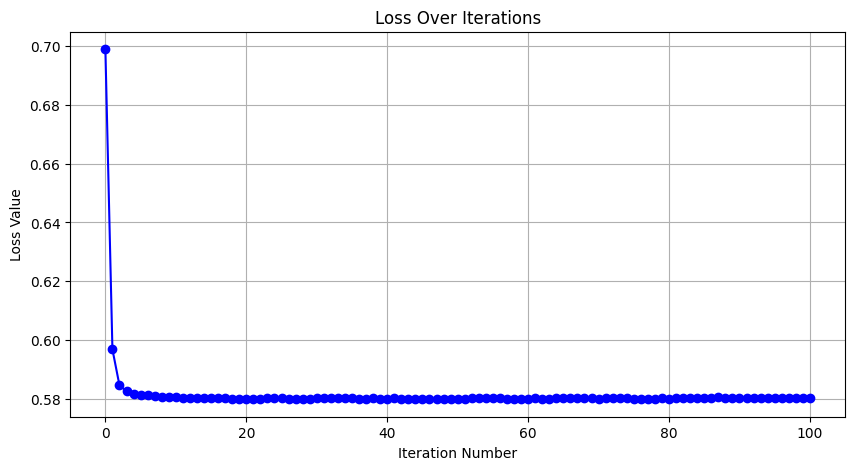

In [90]:
plot_val_loss(best_loss, loss_vals)

In [35]:
from collections import Counter
def eval(best_model_weights):
    clone_model_inference = HateSpeechTransformer(output_dim, dropout).to(device)
    clone_model_inference.load_state_dict(best_model_weights)
    clone_model_inference.eval()

    with torch.inference_mode():
        test_pred = clone_model_inference(sent_transformer.encode(last_test_data['tweet'].tolist(), convert_to_tensor=True))
        test_pred = torch.softmax(test_pred, dim=-1)
        test_loss = criterion(test_pred, torch.tensor(last_test_data['label'].tolist(), device=device))

        # Convert the predictions to labels
        test_pred_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_pred]

        # Calculate the number of correct predictions
        hard_test_labels = [1 if pred[0] >= 0.5 else 0 for pred in last_test_data['label'].tolist()]
        correct_predictions = sum(1 for pred, true_label in zip(test_pred_labels, hard_test_labels) if pred == true_label)

        # Calculate the total number of instances in the test set
        total_instances = len(last_test_data)

        # Calculate the accuracy
        test_accuracy = correct_predictions / total_instances

        f1 = f1_score(hard_test_labels, test_pred_labels)

        # Calculate the distribution of ones and zeros
        label_distribution = Counter(test_pred_labels)

        return test_accuracy, f1, label_distribution, test_loss

In [80]:
best_table = table

In [84]:
clone_model = HateSpeechTransformer(output_dim, dropout).to(device)
import ast
# Train the clone model
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(clone_model.parameters(), lr=0.0001)

batch_size = 32

# Define number of epochs
num_epoch = 100

loss_vals = []
best_loss = float('inf')

scaler = GradScaler()

repeated_counts = []

# Training loop
new_train_data = best_table['tweet'].tolist()
new_train_data_label = best_table['t_out'].tolist()
new_train_data_label = [[i, 1-i] for i in new_train_data_label]

for epoch in range(num_epoch):
    if epoch == 0:
        # Evaluation
        clone_model.eval()

        with torch.inference_mode():

            # Validation set
            inputs = test_data['tweet'].tolist()

            encoded_text_test = sent_transformer.encode(inputs, convert_to_tensor=True)

            test_pred = clone_model(encoded_text_test)
            test_pred = torch.softmax(test_pred, dim=-1)
            test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

            # Convert the predictions to labels
            test_pred_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_pred]

            # Calculate the number of correct predictions
            hard_test_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_data['label'].tolist()]
            correct_predictions = sum(1 for pred, true_label in zip(test_pred_labels, hard_test_labels) if pred == true_label)

            # Calculate the total number of instances in the test set
            total_instances = len(test_data)

            # Calculate the accuracy
            test_accuracy = correct_predictions / total_instances

            f1 = f1_score(hard_test_labels, test_pred_labels)

        loss_val = test_loss.item()
        loss_vals.append(loss_val)
        print(f'Epoch [{epoch}], Loss: {loss_val}, Accuracy: {test_accuracy}, F1: {f1}')

    for i in range(0, len(new_train_data), batch_size):
        clone_model.train()

        input_texts = new_train_data[i:batch_size + i]

        target_labels = new_train_data_label[i:batch_size + i]

        target_outputs = torch.tensor(target_labels).to(device)

        with torch.inference_mode():
            encoded_text = sent_transformer.encode(input_texts, convert_to_tensor=True)

        # Forward pass through the clone model
        with autocast():
            clone_logits = clone_model(encoded_text)
            clone_outputs = torch.softmax(clone_logits, dim=-1)
            loss = criterion(clone_outputs, target_outputs)

        optimizer.zero_grad()

        scaler.scale(loss).backward()

        # Update model weights considering the scaled gradients
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()
        # scheduler.step()  # Update learning rate decay

    # Evaluation
    clone_model.eval()

    with torch.inference_mode():

        # Validation set
        inputs = test_data['tweet'].tolist()

        encoded_text_test = sent_transformer.encode(inputs, convert_to_tensor=True)

        test_pred = clone_model(encoded_text_test)

        test_pred = torch.softmax(test_pred, dim=-1)

        test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

        # Convert the predictions to labels
        test_pred_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_pred]

        # Calculate the number of correct predictions
        hard_test_labels = [1 if pred[0] >= 0.5 else 0 for pred in test_data['label'].tolist()]
        correct_predictions = sum(1 for pred, true_label in zip(test_pred_labels, hard_test_labels) if pred == true_label)

        # Calculate the total number of instances in the test set
        total_instances = len(test_data)

        # Calculate the accuracy
        test_accuracy = correct_predictions / total_instances

        f1 = f1_score(hard_test_labels, test_pred_labels)

    loss_val = test_loss.item()
    loss_vals.append(loss_val)
    print(f'Epoch [{epoch + 1}], Loss: {loss_val}, Accuracy: {test_accuracy}, F1: {f1}')

    if loss_val < best_loss:
        best_loss = loss_val
        best_model_weights = clone_model.state_dict()
        epoch_counter = 0
    #elif epoch_counter > 12:
    #    break
    else:
        epoch_counter += 1

    epoch += 1

Epoch [0], Loss: 0.7002577781677246, Accuracy: 0.34584342211460856, F1: 0.5139430284857571
Epoch [1], Loss: 0.6105639338493347, Accuracy: 0.8058918482647296, F1: 0.6566738044254105
Epoch [2], Loss: 0.5861102938652039, Accuracy: 0.8159806295399515, F1: 0.7157107231920198
Epoch [3], Loss: 0.5836746096611023, Accuracy: 0.8171912832929782, F1: 0.7256208358570563
Epoch [4], Loss: 0.5826834440231323, Accuracy: 0.8208232445520581, F1: 0.7302551640340219
Epoch [5], Loss: 0.5821632742881775, Accuracy: 0.8175948345439871, F1: 0.7283653846153846
Epoch [6], Loss: 0.5817205905914307, Accuracy: 0.8167877320419693, F1: 0.7278177458033572
Epoch [7], Loss: 0.5817298293113708, Accuracy: 0.8192090395480226, F1: 0.7274939172749391
Epoch [8], Loss: 0.5813685655593872, Accuracy: 0.8192090395480226, F1: 0.7281553398058253
Epoch [9], Loss: 0.5811603665351868, Accuracy: 0.8204196933010492, F1: 0.7317661241711875
Epoch [10], Loss: 0.5809474587440491, Accuracy: 0.8184019370460048, F1: 0.7324613555291319
Epoch [1

In [86]:
eval(best_model_weights)

(0.8071803146430012,
 0.7246543778801844,
 Counter({1: 851, 0: 1628}),
 tensor(0.5875, device='cuda:0'))

Best Loss: 0.5793031454086304  at iteration:  72


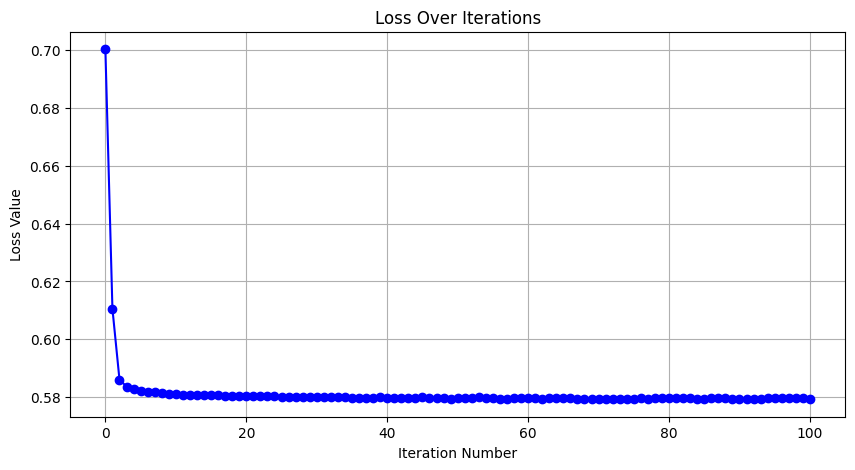

In [87]:
plot_val_loss(best_loss, loss_vals)

In [48]:
table

,tweet,embedding,t_out,c_out,count
0,That nigga john ain't ah Real older nigga Forr...,"[-0.03426282852888107, 0.044211845844984055, -...",0.128351,0.475512,1.0
1,I'm glad Ari know to text me or get in contact...,"[0.022101491689682007, -0.0861954316496849, 0....",0.920739,0.478253,1.0
2,RT @AsiaCakesss: Y'all be makin your nigga mic...,"[-0.03964371234178543, 0.042601920664310455, 0...",0.746024,0.482056,1.0
3,@kieffer_jason bye bitch,"[-0.08758193999528885, -0.011767691932618618, ...",0.175773,0.480036,1.0
4,Abed looks like he has to take a shit #bro #pi...,"[-0.03159087523818016, 0.04301058128476143, 0....",0.185180,0.484723,1.0
...,...,...,...,...,...
12539,RT @HootieGang4Ever: Des bitches swear dey fai...,"[-0.05050087720155716, 0.08379631489515305, 0....",0.297148,0.475763,1.0
12540,"@Wow_Bullet ""cuz i thought i got a wife, but i...","[-0.0830501839518547, -0.015511921606957912, 0...",0.238477,0.471452,1.0
12541,RT @Lil_A47: @Vonteeeeee typical coon activity,"[-0.08696568012237549, 0.003545443993061781, 0...",0.387419,0.483138,1.0
12542,@StayGetNutty what u doing bitch boy,"[-0.048657819628715515, 0.020620573312044144, ...",0.240375,0.473536,1.0
